In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision import datasets
from torchvision import utils
from RLAlg.alg.gan import GAN
from RLAlg.nn.layers import MLPLayer, CriticHead
from RLAlg.utils import weight_init
from RLAlg.nn.steps import ValueStep

In [ ]:
DATA_PATH = './data'
BATCH_SIZE = 128
IMAGE_CHANNEL = 1
Z_DIM = 100
EPOCH_NUM = 5
lr = 1e-3
seed = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = datasets.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

In [4]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.model = nn.Sequential(
            MLPLayer(Z_DIM, 256, nn.SiLU(), True),
            MLPLayer(256, 512, nn.SiLU(), True),
            MLPLayer(512, 1024, nn.SiLU(), True),
            MLPLayer(1024, IMAGE_CHANNEL * 28 * 28, nn.Tanh())
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), IMAGE_CHANNEL, 28, 28)
        return img
    
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.model = nn.Sequential(
            MLPLayer(IMAGE_CHANNEL * 28 * 28, 1024, nn.SiLU(), True),
            MLPLayer(1024, 512, nn.SiLU(), True),
            MLPLayer(512, 256, nn.SiLU(), True),
            CriticHead(256)
        )

        weight_init(self.model[-1])

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [5]:
g = G().to(device)
d = D().to(device)

g_optimizer = torch.optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
for epoch in range(20):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        z = torch.randn(real_imgs.size(0), Z_DIM).to(device)
        fake_imgs = g(z)
        d_loss_dict = GAN.compute_bce_loss(d, real_imgs, fake_imgs, r1_gamma=10.0)

        d_loss = d_loss_dict["loss"]
        d_loss_real = d_loss_dict["loss_real"]
        d_loss_fake = d_loss_dict["loss_fake"]
        d_loss_gp = d_loss_dict["gradient_penalty"]

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(real_imgs.size(0), Z_DIM).to(device)
        fake_imgs = g(z)
        g_loss_dict = GAN.compute_generator_mean_loss(d, fake_imgs)
        g_loss = g_loss_dict["loss"]

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{EPOCH_NUM}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

Epoch [1/5]  D_loss: 1.3265  G_loss: 0.1043
Epoch [2/5]  D_loss: 1.2971  G_loss: 0.0911
Epoch [3/5]  D_loss: 1.3349  G_loss: 0.1629
Epoch [4/5]  D_loss: 1.3181  G_loss: 0.1321
Epoch [5/5]  D_loss: 1.3304  G_loss: 0.0934
Epoch [6/5]  D_loss: 1.3470  G_loss: 0.0988
Epoch [7/5]  D_loss: 1.3315  G_loss: 0.0781
Epoch [8/5]  D_loss: 1.3336  G_loss: 0.0839
Epoch [9/5]  D_loss: 1.3339  G_loss: 0.0884
Epoch [10/5]  D_loss: 1.3513  G_loss: 0.0834
Epoch [11/5]  D_loss: 1.3496  G_loss: 0.0725
Epoch [12/5]  D_loss: 1.3405  G_loss: 0.0890
Epoch [13/5]  D_loss: 1.3385  G_loss: 0.0819
Epoch [14/5]  D_loss: 1.3417  G_loss: 0.0839
Epoch [15/5]  D_loss: 1.3404  G_loss: 0.0897
Epoch [16/5]  D_loss: 1.3403  G_loss: 0.0661
Epoch [17/5]  D_loss: 1.3456  G_loss: 0.0829
Epoch [18/5]  D_loss: 1.3502  G_loss: 0.0743
Epoch [19/5]  D_loss: 1.3531  G_loss: 0.0582
Epoch [20/5]  D_loss: 1.3569  G_loss: 0.0571


In [7]:
img_list = []
with torch.no_grad():
    viz_noise = torch.randn(64, Z_DIM).to(device)
    fake = g(viz_noise).detach().cpu()
img_list.append(utils.make_grid(fake, padding=2, normalize=True))

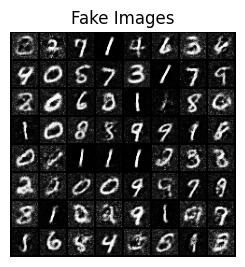

In [8]:
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()